In [1]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from efficientnet.keras import EfficientNetB5
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
class MyCallback(Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.batches == 0 and epoch > 0:
            tr_acc = logs.get('accuracy')
            v_loss = logs.get('val_loss')

            if tr_acc > self.highest_tracc:
                self.highest_tracc = tr_acc

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.count = 0
            else:
                self.count += 1

            if tr_acc >= self.threshold:
                self.ask_epoch -= 1

            if self.count == self.patience and self.ask_epoch > 0:
                print("\nEpoch %d: Accuracy threshold reached. Decreasing learning rate." % (epoch + 1))
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print("Learning rate decreased from %f to %f" % (old_lr, new_lr))
                self.count = 0

            if self.count == self.patience and self.ask_epoch == 0:
                self.stop_count += 1
                if self.stop_count == self.stop_patience:
                    print("\nTraining stopped at epoch %d" % (epoch + 1))
                    self.model.stop_training = True
                else:
                    print("\nEpoch %d: Learning rate adjustment limit reached. Restoring best weights." % (epoch + 1))
                    self.model.set_weights(self.best_weights)
                    self.count = 0

In [4]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
# List all the categories (subfolders) in the data folder
categories = os.listdir(data_path)

# Assign labels to the categories
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 240
data = []
target = []

# Load the image data and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            # Convert the image to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Convert the grayscale image to RGB by replicating the single channel three times
            rgb_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
            # Resize the image to the desired size
            resized_img = cv2.resize(rgb_img, (img_size, img_size))
            # Normalize the image
            normalized_img = resized_img / 255.0
            # Append the image and its corresponding label to the data and target lists
            data.append(normalized_img)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [21]:
!pip install tensorflow-addons


In [22]:
# Convert the data and target lists to numpy arrays
data = np.array(data, dtype='float32')
target = np.array(target)

# Apply SMOTE oversampling to the data
smote = SMOTE(random_state=42)
data_res, target_res = smote.fit_resample(data.reshape(data.shape[0], -1), target)
data_res = data_res.reshape(data_res.shape[0], img_size, img_size, 3)
target_res = np_utils.to_categorical(target_res)

# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(data_res, target_res, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

import tensorflow_addons as tfa
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Reshape
# Construct the EfficientNetB3 model
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3), pooling='max')

# Define the attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.W_v = self.add_weight(name="W_v", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k)
        v = tf.matmul(x, self.W_v)

        attn_score = tf.matmul(q, k, transpose_b=True)
        attn_score = tf.nn.softmax(attn_score, axis=-1)

        output = tf.matmul(attn_score, v)
        return output

# Modify your model to include the attention layer
model = Sequential([
    base_model,
    Reshape((1, 1, 2048)),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    AttentionLayer(),  # Add attention layer
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(512, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.45, seed=123),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.45, seed=123),
    Dense(len(categories), activation='softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 reshape_4 (Reshape)         (None, 1, 1, 2048)        0         
                                                                 
 batch_normalization_20 (Bat  (None, 1, 1, 2048)       8192      
 chNormalization)                                                
                                                                 
 attention_layer_2 (Attentio  (None, 1, 1, 2048)       12582912  
 nLayer)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 1, 1, 256)         4718848   
                                                      

In [23]:
# Define the callbacks
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
my_callback = MyCallback(model=model, patience=10, stop_patience=5, threshold=0.9, factor=0.1, batches=10, epochs=100, ask_epoch=10)

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[checkpoint, my_callback])

Epoch 1/100


2024-01-16 07:31:04.920423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnet-b5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


116/116 [==============================] - ETA: 0s - loss: 11.5565 - accuracy: 0.3373
Epoch 1: val_accuracy improved from -inf to 0.30583, saving model to /kaggle/working/best_model.h5
116/116 [==============================] - 174s 489ms/step - loss: 11.5565 - accuracy: 0.3373 - val_loss: 10.1340 - val_accuracy: 0.3058
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 10.4872 - accuracy: 0.4535
Epoch 2: val_accuracy improved from 0.30583 to 0.47087, saving model to /kaggle/working/best_model.h5
116/116 [==============================] - 51s 442ms/step - loss: 10.4872 - accuracy: 0.4535 - val_loss: 9.5378 - val_accuracy: 0.4709
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 9.6633 - accuracy: 0.5422
Epoch 3: val_accuracy did not improve from 0.47087
116/116 [==============================] - 49s 419ms/step - loss: 9.6633 - accuracy: 0.5422 - val_loss: 8.8231 - val_accuracy: 0.3835
Epoch 4/100
116/116 [==============================] - ETA: 0

In [ ]:
'''batch_size = 40     # set batch size for training
epochs = 40         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))'''

In [24]:
# Load the best weights
model.load_weights('/kaggle/working/best_model.h5')

In [25]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.7269397377967834
Test accuracy: 0.9085603356361389


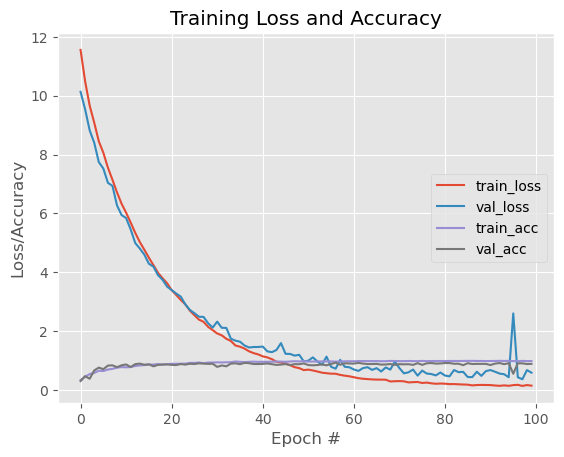

In [26]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")



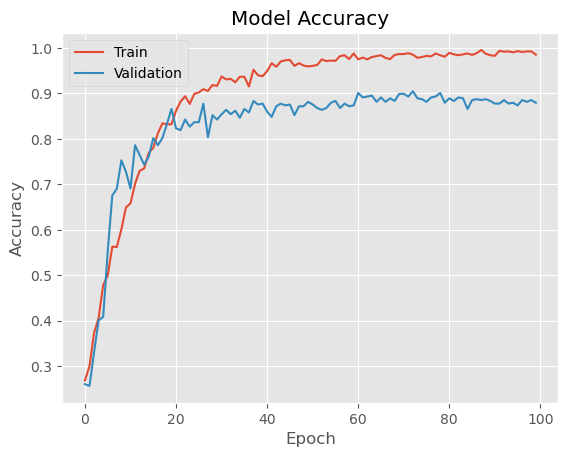

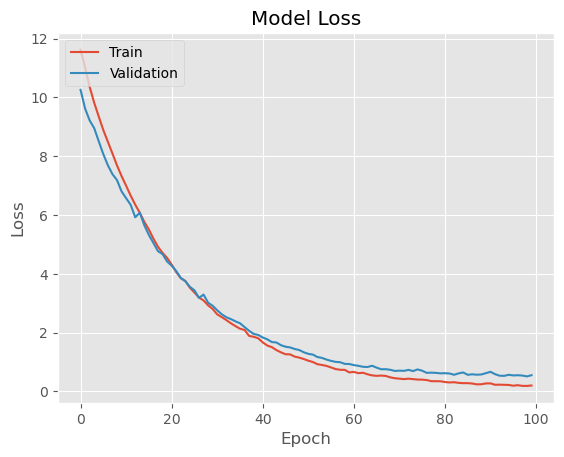

In [18]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

17/17 [==============================] - 7s 130ms/step


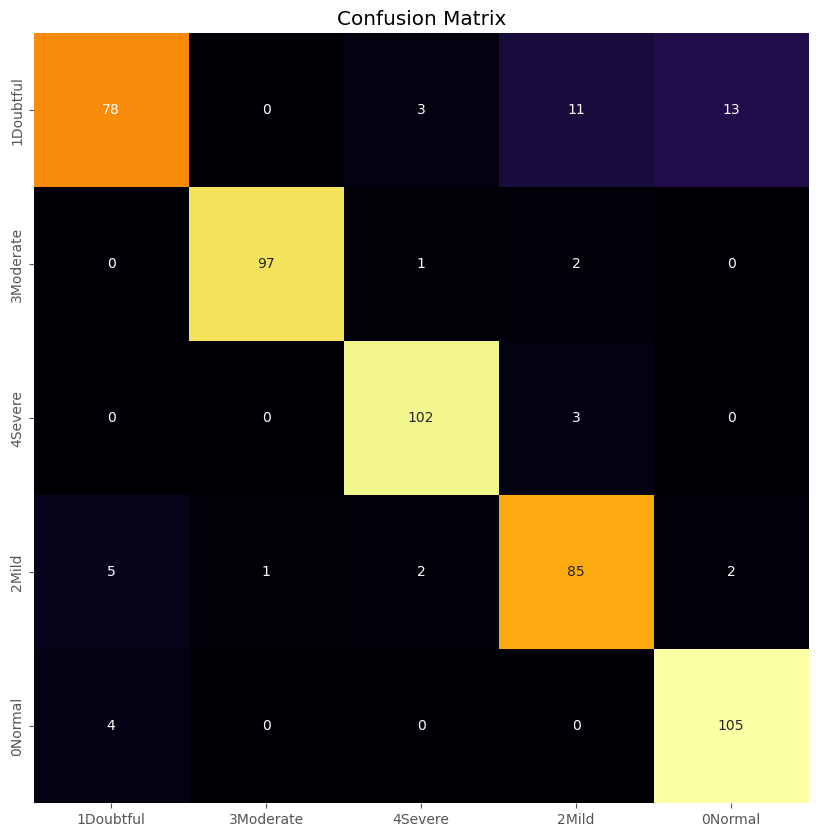

In [29]:
import seaborn as sns
# Generate and plot the confusion matrix with 'inferno' colormap using seaborn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', cbar=False,
            xticklabels=categories, yticklabels=categories, annot_kws={"size": 10})
plt.title('Confusion Matrix')
plt.show()


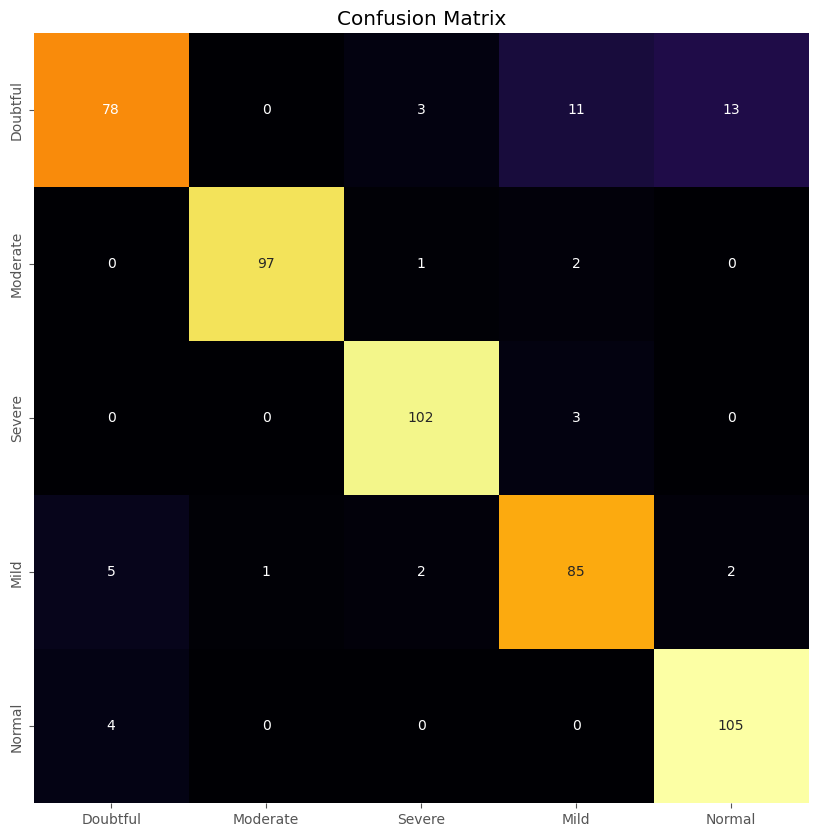

In [30]:
# Generate and plot the confusion matrix with 'inferno' colormap using seaborn
cm = confusion_matrix(y_true, y_pred)
class_names = ['Doubtful', 'Moderate', 'Severe', 'Mild', 'Normal']
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10})
plt.title('Confusion Matrix')
# Save the figure as a PDF
plt.savefig('conf.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [31]:
# Print the classification report
report = classification_report(y_true, y_pred, target_names=categories)
print(report)


              precision    recall  f1-score   support

   1Doubtful       0.90      0.74      0.81       105
   3Moderate       0.99      0.97      0.98       100
     4Severe       0.94      0.97      0.96       105
       2Mild       0.84      0.89      0.87        95
     0Normal       0.88      0.96      0.92       109

    accuracy                           0.91       514
   macro avg       0.91      0.91      0.91       514
weighted avg       0.91      0.91      0.91       514



In [32]:
print("Number of images before SMOTE:", data.shape[0])
print("Number of images after SMOTE:", data_res.shape[0])


Number of images before SMOTE: 1650
Number of images after SMOTE: 2570


In [33]:
import pandas as pd
# Print class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(target).value_counts())

print("\nClass distribution after SMOTE:")
print(pd.Series(np.argmax(target_res, axis=1)).value_counts())

Class distribution before SMOTE:
4    514
0    477
3    232
1    221
2    206
dtype: int64

Class distribution after SMOTE:
0    514
1    514
2    514
3    514
4    514
dtype: int64


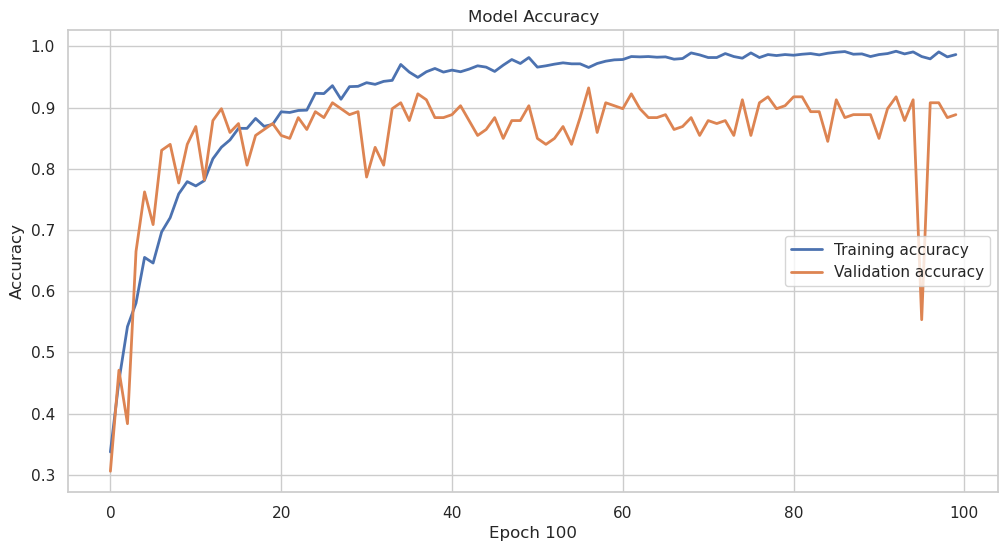

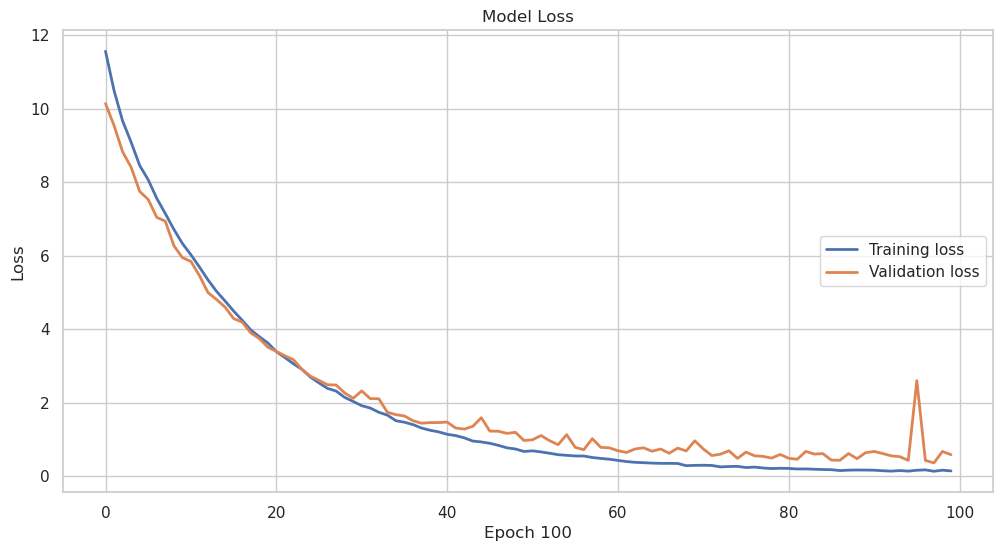

In [35]:
import seaborn as sns

# Function to plot better-looking accuracy and loss curves
def plot_curves(history, metric, title, ylabel, legend_loc='upper right'):
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    plt.plot(history.history[metric], label=f'Training {metric}', linewidth=2)
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linewidth=2)

    plt.title(title)
    plt.xlabel('Epoch 100')
    plt.ylabel(ylabel)
    plt.legend(loc='center right')
    plt.grid(True)
    
    # Save the figure as a PDF
    plt.savefig('_training_plot.pdf', format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

# Plot the better-looking training and validation accuracy curves
plot_curves(history, 'accuracy', 'Model Accuracy', 'Accuracy')

# Plot the better-looking training and validation loss curves
plot_curves(history, 'loss', 'Model Loss', 'Loss')



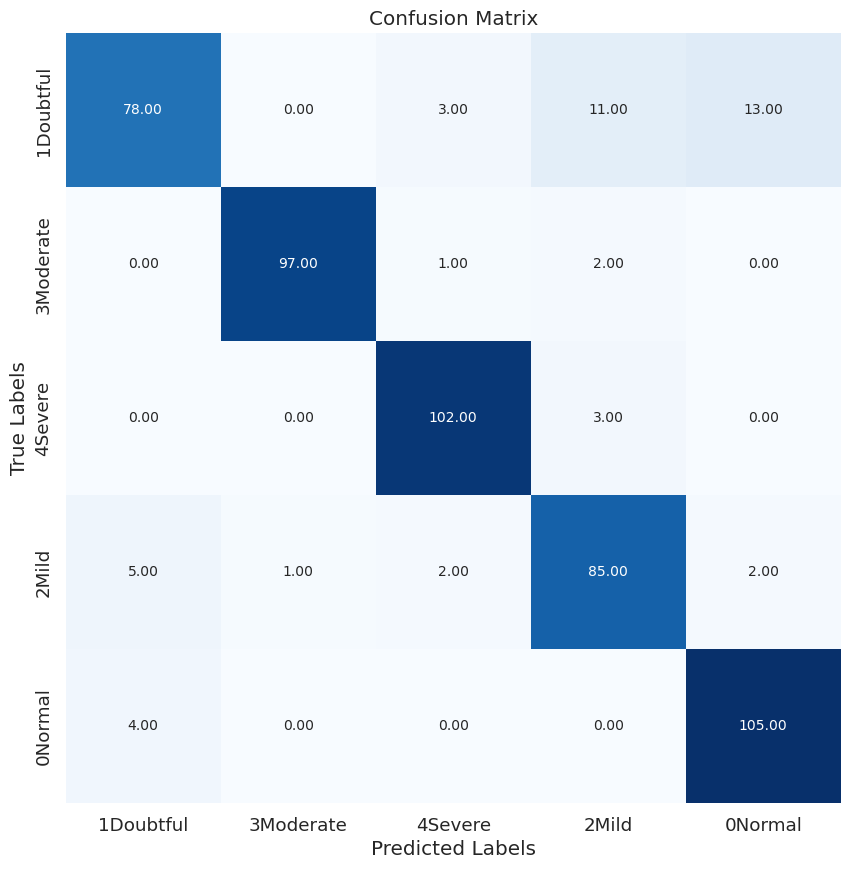

In [36]:
import seaborn as sns

# Function to plot better-looking confusion matrix
def plot_confusion_matrix(cm, class_names, normalize=True, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    fmt = '.2f' if normalize else 'd'
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10})
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Generate and plot the better-looking confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names=categories)


17/17 [==============================] - 2s 129ms/step


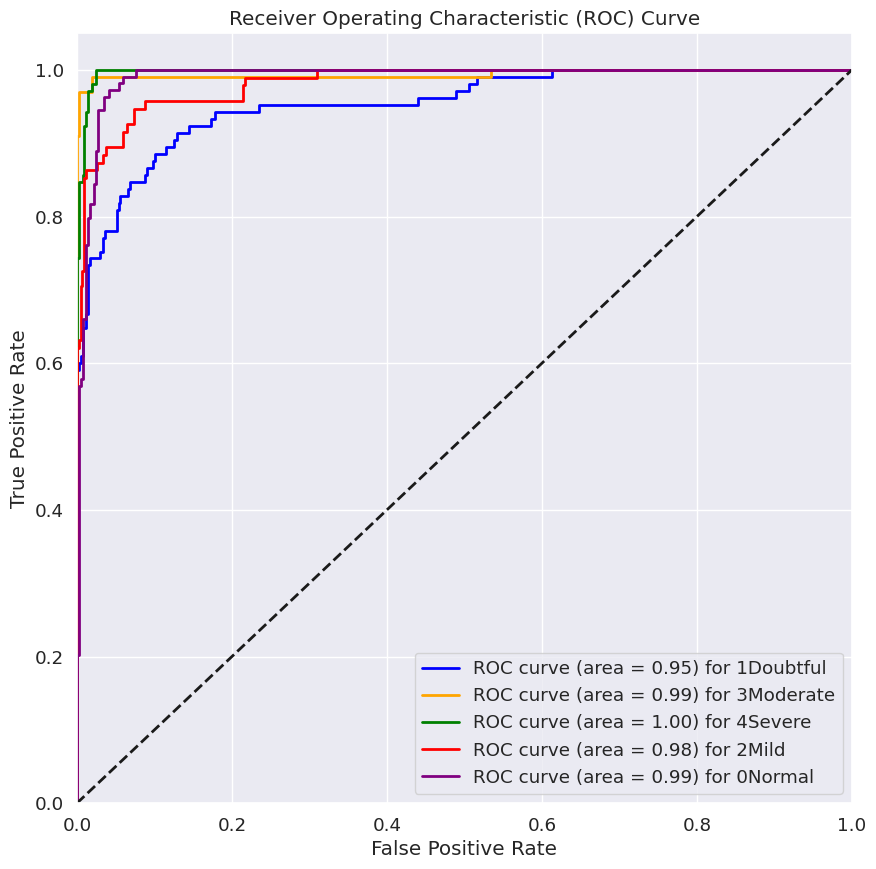

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert labels to binary format for ROC curve
y_test_bin = label_binarize(y_true, classes=np.arange(len(categories)))

# Make predictions on the test data
y_pred_proba = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 10))

colors = cycle(['blue', 'orange', 'green', 'red', 'purple'])
for i, color in zip(range(len(categories)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for {categories[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


17/17 [==============================] - 2s 129ms/step


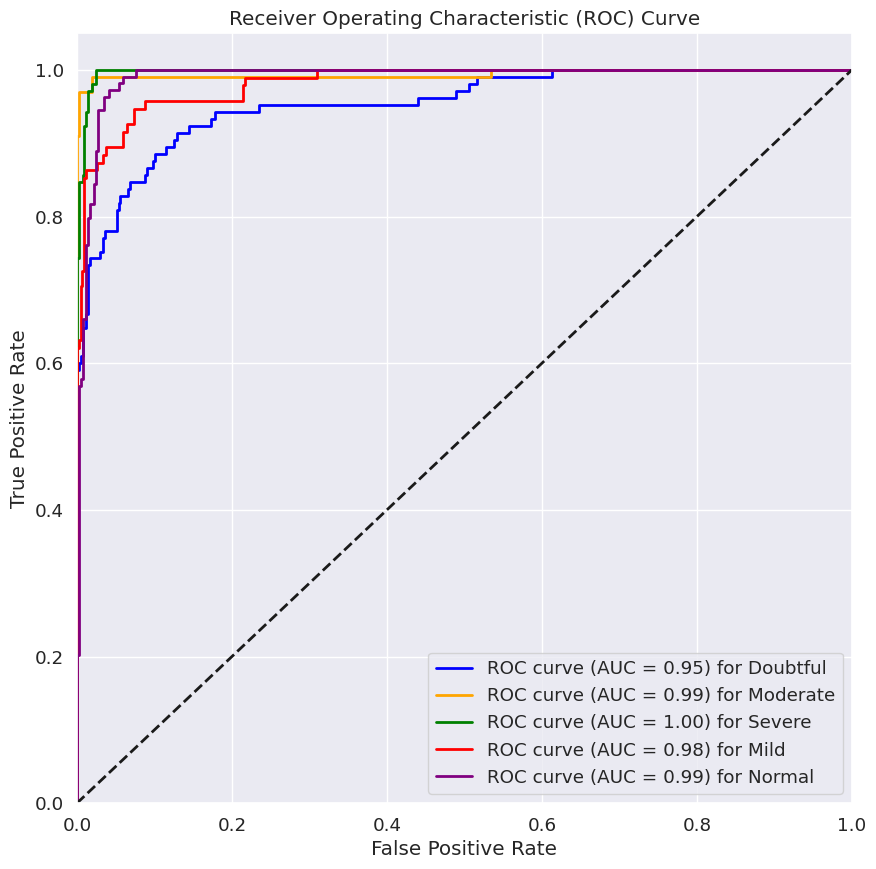

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert labels to binary format for ROC curve
y_test_bin = label_binarize(y_true, classes=np.arange(len(categories)))

# Make predictions on the test data
y_pred_proba = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 10))

class_names = ['Doubtful', 'Moderate', 'Severe', 'Mild', 'Normal']
colors = cycle(['blue', 'orange', 'green', 'red', 'purple'])
for i, color in zip(range(len(categories)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
# Save the figure as a PDF
plt.savefig('roc.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [40]:
!pip install tf_explain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00


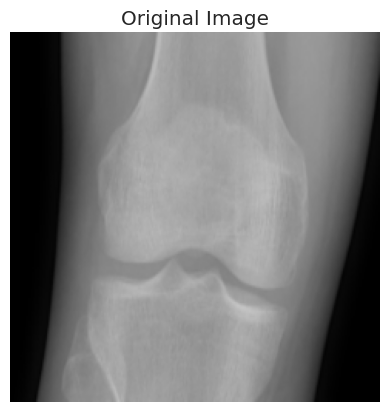

1/1 [==============================] - 1s 542ms/step
True class: 0Normal
Predicted class: 0Normal


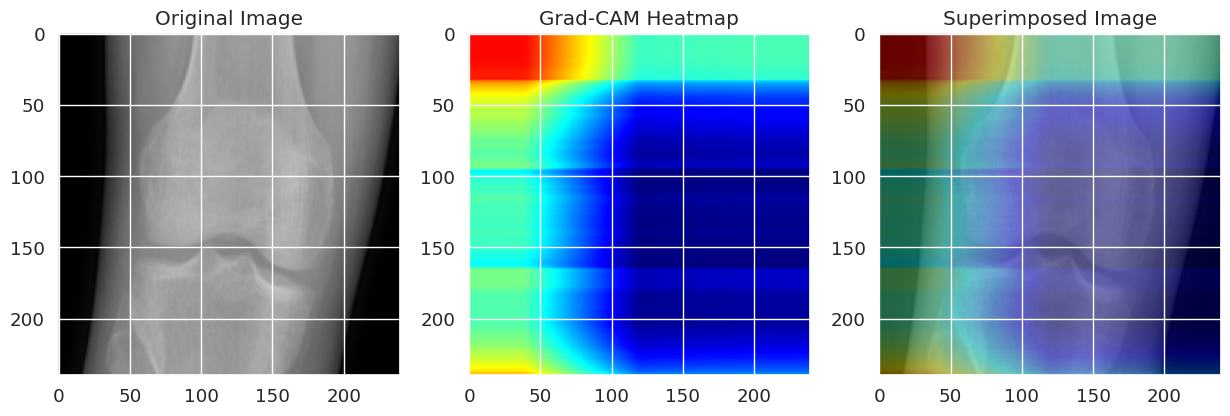

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.grad_cam import GradCAM

# ... (Your existing code for model training and evaluation)

# Now, let's integrate Grad-CAM into your script

# Choose a random image from the test set
index = np.random.randint(len(x_test))
sample_image = x_test[index]
label = np.argmax(y_test[index])

# Display the original image
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Preprocess the image for prediction
sample_image = img_to_array(sample_image)
sample_image = preprocess_input(sample_image)
sample_image = np.expand_dims(sample_image, axis=0)

# Perform prediction
predictions = model.predict(sample_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class = categories[predicted_class_index]

# Print the predicted class and the true class
true_class = categories[label]
print("True class:", true_class)
print("Predicted class:", predicted_class)

# Generate Grad-CAM heatmap
explainer = GradCAM()
gradcam = explainer.explain((sample_image, None), model, predicted_class_index)
heatmap = cv2.resize(gradcam[0], (sample_image.shape[2], sample_image.shape[1]))

# Convert the heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert sample_image[0] to uint8
sample_image_uint8 = cv2.convertScaleAbs(sample_image[0] * 255.0)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(sample_image_uint8, 0.6, heatmap, 0.4, 0)

# Plot the original image, heatmap, and superimposed image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_image_uint8)
axes[0].set_title('Original Image')

axes[1].imshow(heatmap)
axes[1].set_title('Grad-CAM Heatmap')

axes[2].imshow(superimposed_img)
axes[2].set_title('Superimposed Image')

plt.show()
